Accident video Extraction from youtube (one is manually added)

In [ ]:
# !pip install yt_dlp
from yt_dlp import YoutubeDL
import os

def download_multiple_videos(url_list, output_path='/content/drive/MyDrive/accident_detector/videos'):
    os.makedirs(output_path, exist_ok=True)

    for idx, url in enumerate(url_list, start=1):
        ydl_opts = {
            'outtmpl': f'{output_path}/video{idx}.%(ext)s',  #saving as video1.mp4, video2.mp4 bla bla bla
            'format': 'bestvideo+bestaudio/best',
            'merge_output_format': 'mp4',
            'quiet': False,
        }

        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])

# List your video URLs here
video_urls = [
    'https://www.youtube.com/watch?v=zRBb1H4eo_U',
    'https://www.youtube.com/watch?v=wGiNv0E1zTk',
    'https://www.youtube.com/watch?v=3nRi9ic1gi8',
]

download_multiple_videos(video_urls, output_path='/content/drive/MyDrive/accident_detector/videos')


[youtube] Extracting URL: https://www.youtube.com/watch?v=zRBb1H4eo_U
[youtube] zRBb1H4eo_U: Downloading webpage
[youtube] zRBb1H4eo_U: Downloading tv client config
[youtube] zRBb1H4eo_U: Downloading tv player API JSON
[youtube] zRBb1H4eo_U: Downloading ios player API JSON
[youtube] zRBb1H4eo_U: Downloading m3u8 information
[info] zRBb1H4eo_U: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 9
[download] Destination: /content/drive/MyDrive/accident_detector/videos/video1.f616.mp4
[download] 100% of   22.21MiB in 00:00:01 at 14.08MiB/s               
[download] Destination: /content/drive/MyDrive/accident_detector/videos/video1.f251.webm
[download] 100% of  759.77KiB in 00:00:00 at 10.14MiB/s  
[Merger] Merging formats into "/content/drive/MyDrive/accident_detector/videos/video1.mp4"
Deleting original file /content/drive/MyDrive/accident_detector/videos/video1.f251.webm (pass -k to keep)
Deleting original file /content/drive/MyDrive/acc

Extracting frames from videos to create training dataset (accident clips)

In [ ]:
import cv2
import os

def extract_frames_from_videos(video_dir, output_dir, frame_rate=1):
    os.makedirs(output_dir, exist_ok=True)
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

    for vid_index, video_file in enumerate(video_files, start=1):
        video_path = os.path.join(video_dir, video_file)
        output_subdir = os.path.join(output_dir, f'video{vid_index}')
        os.makedirs(output_subdir, exist_ok=True)

        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps * frame_rate)

        count = 0
        saved = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if count % frame_interval == 0:
                frame_filename = os.path.join(output_subdir, f'frame{saved}.jpg')
                cv2.imwrite(frame_filename, frame)
                saved += 1
            count += 1

        cap.release()
        print(f"Extracted {saved} frames from {video_file} → {output_subdir}")

# Set your paths
video_dir = '/content/drive/MyDrive/accident_detector/videos'
output_dir = '/content/drive/MyDrive/accident_detector/images/accident'

extract_frames_from_videos(video_dir, output_dir)


Extracted 46 frames from video1.mp4 → /content/drive/MyDrive/accident_detector/images/accident/video1
Extracted 330 frames from video2.mp4 → /content/drive/MyDrive/accident_detector/images/accident/video2
Extracted 297 frames from video3.mp4 → /content/drive/MyDrive/accident_detector/images/accident/video3
Extracted 260 frames from video4.mp4 → /content/drive/MyDrive/accident_detector/images/accident/video4


Extracting frames from videos to create training dataset (non accident)

In [ ]:
import cv2
import os

# Paths
video_dir = '/content/drive/MyDrive/accident_detector/videos/non_accident'
output_dir = '/content/drive/MyDrive/accident_detector/dataset/train/non_accident'
os.makedirs(output_dir, exist_ok=True)

# Settings
frames_per_second = 1  # 1 image per second

video_files = sorted([f for f in os.listdir(video_dir) if f.endswith('.mp4')])

for vid_idx, video_file in enumerate(video_files, start=1):
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = int(total_frames / fps)

    print(f"Processing {video_file} ({duration} seconds)")

    frame_count = 0
    saved_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if int(frame_count % fps) == 0:
            img_path = os.path.join(output_dir, f'{video_file[:-4]}_frame{saved_count}.jpg')
            cv2.imwrite(img_path, frame)
            saved_count += 1
        frame_count += 1

    cap.release()

print("✅ Non-accident frame extraction complete.")

Processing video1.mp4 (217 seconds)
Processing video2.mp4 (229 seconds)
Processing video3.mp4 (286 seconds)
✅ Non-accident frame extraction complete.


In [11]:
import os
import shutil

def flatten_accident_frames(root_dir):
    for subdir in os.listdir(root_dir):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path) and file.endswith('.jpg'):
                    new_filename = f"{subdir}_{file}"
                    shutil.move(file_path, os.path.join(root_dir, new_filename))
            os.rmdir(subdir_path)  # remove the now-empty folder

# Run it on your dataset
flatten_accident_frames('/content/drive/MyDrive/accident_detector/dataset/train/accident')


Spliting into Train test and Val (80-10-10)

In [12]:
import os
import random
import shutil

def split_data(source_dir, val_dir, test_dir, val_ratio=0.1, test_ratio=0.1):
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]
    random.shuffle(files)

    total = len(files)
    val_count = int(val_ratio * total)
    test_count = int(test_ratio * total)

    val_files = files[:val_count]
    test_files = files[val_count:val_count + test_count]

    for f in val_files:
        shutil.move(os.path.join(source_dir, f), os.path.join(val_dir, f))

    for f in test_files:
        shutil.move(os.path.join(source_dir, f), os.path.join(test_dir, f))

    print(f"Moved {len(val_files)} to {val_dir}")
    print(f"Moved {len(test_files)} to {test_dir}")

# ACCIDENT class
split_data(
    source_dir='/content/drive/MyDrive/accident_detector/dataset/train/accident',
    val_dir='/content/drive/MyDrive/accident_detector/dataset/val/accident',
    test_dir='/content/drive/MyDrive/accident_detector/dataset/test/accident'
)

# NON-ACCIDENT class
split_data(
    source_dir='/content/drive/MyDrive/accident_detector/dataset/train/non_accident',
    val_dir='/content/drive/MyDrive/accident_detector/dataset/val/non_accident',
    test_dir='/content/drive/MyDrive/accident_detector/dataset/test/non_accident'
)


Moved 93 to /content/drive/MyDrive/accident_detector/dataset/val/accident
Moved 93 to /content/drive/MyDrive/accident_detector/dataset/test/accident
Moved 73 to /content/drive/MyDrive/accident_detector/dataset/val/non_accident
Moved 73 to /content/drive/MyDrive/accident_detector/dataset/test/non_accident


Shape of the dataset

  plt.tight_layout()



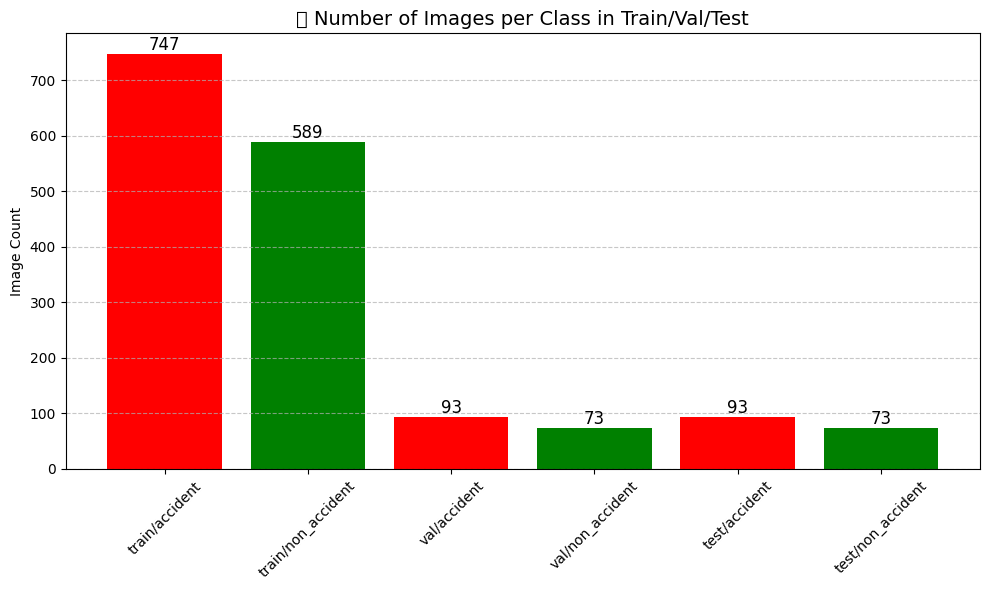

In [16]:
import os
import matplotlib.pyplot as plt

base_dir = '/content/drive/MyDrive/accident_detector/dataset'

def count_images(dataset_dir):
    counts = {}
    for split in ['train', 'val', 'test']:
        for label in ['accident', 'non_accident']:
            dir_path = os.path.join(dataset_dir, split, label)
            num_images = len([f for f in os.listdir(dir_path) if f.endswith('.jpg')])
            counts[f'{split}/{label}'] = num_images
    return counts

image_counts = count_images(base_dir)

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(image_counts.keys(), image_counts.values(), color=['red', 'green'] * 3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.title("📊 Number of Images per Class in Train/Val/Test", fontsize=14)
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Images Preview

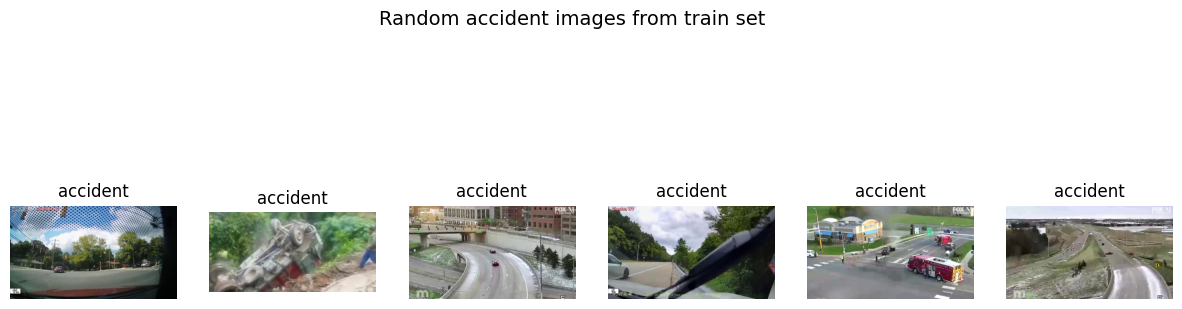

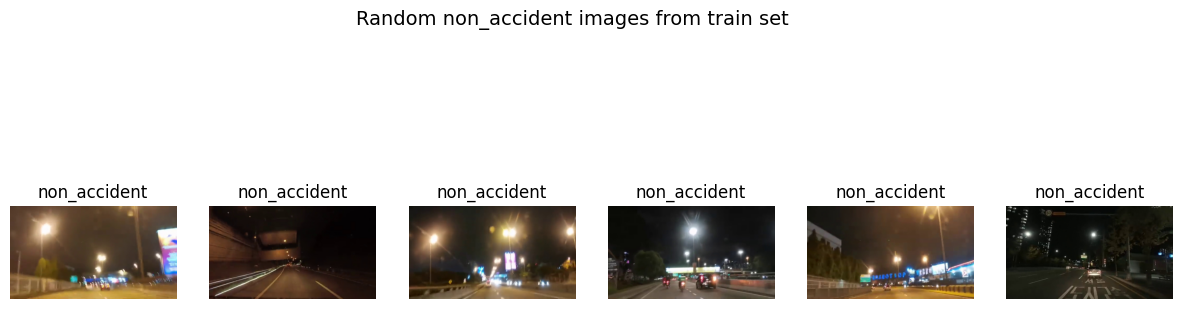

In [17]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

def show_random_images(base_path, category, split='train', num_images=6):
    folder = os.path.join(base_path, split, category)
    images = [os.path.join(folder, img) for img in os.listdir(folder) if img.endswith('.jpg')]
    sample_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{category}")
    plt.suptitle(f"Random {category} images from {split} set", fontsize=14)
    plt.show()

base_path = "/content/drive/MyDrive/accident_detector/dataset"

show_random_images(base_path, "accident", split='train')
show_random_images(base_path, "non_accident", split='train')


Image Dimensions

In [18]:
from tqdm import tqdm
import numpy as np

def get_image_shapes(base_path, split='train'):
    heights, widths = [], []

    for label in ['accident', 'non_accident']:
        folder = os.path.join(base_path, split, label)
        for fname in tqdm(os.listdir(folder), desc=f"{split}/{label}"):
            if fname.endswith('.jpg'):
                img_path = os.path.join(folder, fname)
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                        widths.append(w)
                        heights.append(h)
                except:
                    print(f"Error reading: {img_path}")

    return heights, widths

heights, widths = get_image_shapes(base_path, split='train')

print(f"Image width: min={np.min(widths)}, max={np.max(widths)}, median={np.median(widths)}")
print(f"Image height: min={np.min(heights)}, max={np.max(heights)}, median={np.median(heights)}")


train/non_accident: 100%|██████████| 589/589 [00:02<00:00, 288.07it/s]

Image width: min=1920, max=1920, median=1920.0
Image height: min=924, max=1080, median=1080.0


Preparing dataset (Normalizing and resizing)

In [19]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [20]:
# ImageNet stats for normalization (useful for pretrained models)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Common transform for all splits
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Train, Test, Val shape

In [21]:
data_dir = '/content/drive/MyDrive/accident_detector/dataset'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

print("Classes:", train_dataset.classes)
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Classes: ['accident', 'non_accident']
Train: 1336 | Val: 166 | Test: 166


defining batch size

In [22]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Defining model (ResNet18)

In [23]:
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional, useful if data is small)
for param in model.parameters():
    param.requires_grad = False

# Replace the final FC layer to match our 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.2MB/s]


Defining Loss

In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

Training the model

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        print(f"            Val Accuracy: {val_acc:.4f}\n")


In [26]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

[Epoch 1] Train Loss: 26.5953, Accuracy: 0.6048
            Val Accuracy: 0.7711

[Epoch 2] Train Loss: 20.7591, Accuracy: 0.7949
            Val Accuracy: 0.8434

[Epoch 3] Train Loss: 16.7493, Accuracy: 0.8900
            Val Accuracy: 0.8976

[Epoch 4] Train Loss: 14.4247, Accuracy: 0.9244
            Val Accuracy: 0.9217

[Epoch 5] Train Loss: 12.3744, Accuracy: 0.9379
            Val Accuracy: 0.9277



In [31]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds


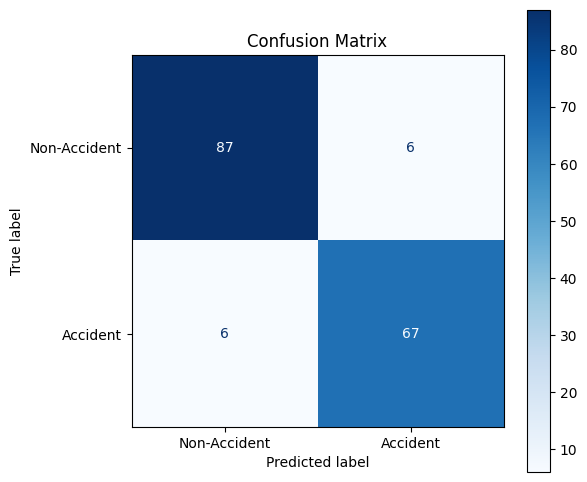

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get labels and predictions on validation or test loader
true_labels, pred_labels = get_predictions(model, val_loader)  # or test_loader

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Accident', 'Accident'])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


🧪 Test Accuracy: 0.9578

📋 Classification Report:
              precision    recall  f1-score   support

Non-Accident       0.96      0.97      0.96        93
    Accident       0.96      0.95      0.95        73

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



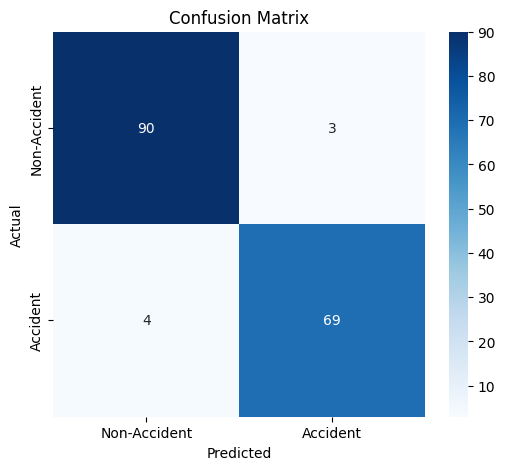

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"🧪 Test Accuracy: {acc:.4f}\n")
    print("📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-Accident', 'Accident']))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Accident', 'Accident'], yticklabels=['Non-Accident', 'Accident'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)


In [38]:
# Save model to disk
torch.save(model.state_dict(), '/content/drive/MyDrive/accident_detector/accident_detection_resnet.pth')
print("✅ Model saved as 'accident_detection_resnet.pth'")

✅ Model saved as 'accident_detection_resnet.pth'
